In [60]:
%load_ext autoreload
%autoreload 2
import math

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import os

from skimage import io, color
from skimage.data import astronaut
from skimage.color import rgb2gray, gray2rgb
from skimage.segmentation import mark_boundaries, find_boundaries
import cv2
from seeds import *
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float

import cv2
import numpy as np
from cv2 import ximgproc
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import math
import itertools
import operator
from skimage.feature import graycoprops
from skimage.feature import graycomatrix
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import aaa
import pickle
import math
from skimage import io, color
import numpy as np
from tqdm import trange
from extraction import *
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import binary_dilation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def map_is_valid_coords_to_target(input_is_valid,
                                  input_origin_mm,
                                  input_voxel_size_mm,
                                  target_shape,
                                  target_origin_mm,
                                  target_voxel_size_mm,
                                  ):

    # voxels in feature space where the features are computed
    valid_voxels = np.argwhere(input_is_valid).T
    valid_voxel_pos = (valid_voxels * input_voxel_size_mm + np.array(input_origin_mm).reshape(3, 1))

    # indices of valid voxels in target space
    valid_target_ind = valid_voxel_pos - np.array(target_origin_mm).reshape(3, 1)
    valid_target_ind = valid_target_ind / target_voxel_size_mm

    # clip values out of range and convert to indexable dtype
    min_index = np.zeros((3, 1))
    max_index = np.array(target_shape).reshape(3, 1) - 1
    valid_target_ind = np.clip(valid_target_ind, min_index, max_index)
    valid_target_ind = np.rint(valid_target_ind).astype('int32')

    return valid_target_ind

In [4]:
#DATA_PATH = "/Users/sunyiyou/cudi_research"
DATA_PATH = "/Volumes/NIH-AA/florian/graph_intermediate"
patient_id = "TULIP/AVL-061"

bmode = aaa.load(os.path.join(DATA_PATH,patient_id,"bmode_texture_cropped_0.aaa"))
ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_lowres_0_75_0.aaa"))
#ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_texture_frames_cropped_0.aaa"))

print(ceus_4d.keys())
print(ceus_4d['data4d'].shape)

dict_keys(['data4d', 'is_valid', 'voxel_size_mm', 'origin_mm', 'timestamps_s', 'dynamic_range_db', 'max_radius_mm', 'scan_settings', 'type'])
(160, 81, 144, 121)


In [13]:
registration_path = "/Volumes/NIH-AA/florian/local-data/annotations_g3g4lt20"

registration_file = open(os.path.join(registration_path,patient_id,"annotations.pkl"), "rb")

registration = pickle.load(registration_file)

print(registration.keys())
print(registration['annotations'])
print(registration['histology_map'].shape)

dict_keys(['origin_mm', 'voxel_size_mm', 'annotations', 'histology_map', 'is_valid'])
['binary_sparse', 'binary', 'dense']
(95, 75, 78, 3)


In [7]:
#img = astronaut()
#img = ceus_4d['data4d'][50:100,:,:,13]
img = bmode['data4d'][50:100,:,:].squeeze()
#img = bmode['data4d'].squeeze()
#mask =  ceus_4d['is_valid'][50:100,:,:]
#img = rgb2gray(img)
print(img.shape)

(50, 226, 234)


In [211]:
a = np.array([[[1,1,1,1],[2,2,2,2],[3,3,3,3]],[[4,4,4,4],[5,5,5,5],[6,6,6,6]]])
#a = np.ones((10,10,10))
#print(np.where(a==1))
#print(np.argwhere(a==1))
print(a[0,1:2,0])
a=[1]
print(np.histogram(a, bins=8, range=[1,9]))

[2]
(array([1, 0, 0, 0, 0, 0, 0, 0]), array([1., 2., 3., 4., 5., 6., 7., 8., 9.]))


In [14]:
valid_target_ind = map_is_valid_coords_to_target( 
                                  
                                  bmode['is_valid'],
                                  bmode['origin_mm'],
                                  bmode['voxel_size_mm'],
                                  registration['is_valid'].shape,
                                  registration['origin_mm'],
                                  registration['voxel_size_mm']
                                  
                                  )
valid_source_ind = np.argwhere(bmode['is_valid']).T
print(valid_source_ind.shape)
sample_size = 20
target = np.full(bmode['is_valid'].shape, np.nan, dtype='float32')
target_mask = np.zeros(bmode['is_valid'].shape,)
#annotation = registration['histology_map'][:,:,:,2]
annotation = crop_image_mask(registration['histology_map'][:,:,:,2],registration['is_valid'])
#print(high_res[valid_source_ind[0,0:sample_size],valid_source_ind[1,0:sample_size],valid_source_ind[2,0:sample_size]].shape)
for i in range(0, valid_source_ind.shape[1], sample_size):
    target[tuple(valid_source_ind[:, i:i + sample_size].reshape(3, -1, 1))] = annotation[tuple(valid_target_ind[:, i:i + sample_size].reshape(3, -1, 1))]
    target_mask[tuple(valid_source_ind[:, i:i + sample_size].reshape(3, -1, 1))] = registration['is_valid'][tuple(valid_target_ind[:, i:i + sample_size].reshape(3, -1, 1))]

(3, 10264158)


(284, 226, 234)


(-0.5, 233.5, 225.5, -0.5)

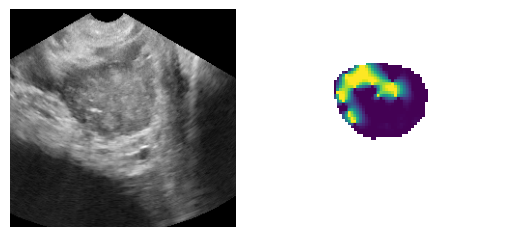

In [20]:
print(target.shape)
plt.subplot(1,2,1)
plt.imshow(bmode['data4d'][75,:,:],cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(target[75,:,:])
plt.axis('off')

In [46]:
def crop_image_mask(gray_image, mask):
    #masked_image = -np.ones(gray_image.shape)
    masked_image = np.full(gray_image.shape,np.nan)
    masked_image[mask == True] = gray_image[mask == True]
    return masked_image


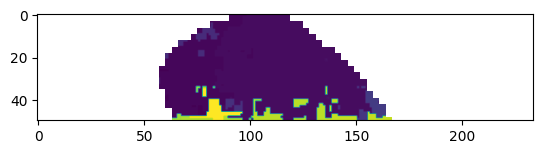

In [50]:
cropped_image = crop_image_mask(p.Segment, target_mask)


In [52]:
print(np.unique(cropped_image,return_counts=True))
print(np.unique(p.Segment[target_mask==True],return_counts=True))

(array([ 3.,  8.,  9., 10., 11., 12., 13., 16., 17., 18., 19., 20., 23.,
       24., 25., 26., 31., 32., 33., 38., 58., 59., 60., 61., 65., 66.,
       67., 68., 72., 73., 74., 75., 80., 81., 82., 88., nan]), array([     87,     201,    2730,    1350,    2864,    5052,     171,
          2664,   56461,  147989,     501,     107,    9070,    2272,
          6231,    6882,   10904,   15828,      99,      61,      89,
           957,    1165,     557,    1186,    2135,    3387,    2177,
           222,    2844,    3003,    2243,     687,    1791,     387,
           126, 2349720]))
(array([ 3.,  8.,  9., 10., 11., 12., 13., 16., 17., 18., 19., 20., 23.,
       24., 25., 26., 31., 32., 33., 38., 58., 59., 60., 61., 65., 66.,
       67., 68., 72., 73., 74., 75., 80., 81., 82., 88.]), array([    87,    201,   2730,   1350,   2864,   5052,    171,   2664,
        56461, 147989,    501,    107,   9070,   2272,   6231,   6882,
        10904,  15828,     99,     61,     89,    957,   1165,    55

In [ ]:
boundary = find_boundaries(segments_slic_3d)
grid = np.count_nonzero(boundary)
print(grid)

In [192]:
segments_slic_3d = slic(img, n_segments=60, compactness=0.25, max_num_iter=10,sigma=1, start_label=1,channel_axis=None)



In [193]:
a,b = np.unique(segments_slic_3d[target_mask==True],return_counts=True)
print(a,b)
print(np.sum(b))
print(np.count_nonzero(target_mask))
num = 0
nos = [] 
num2 = 0
for i, no in enumerate(a):
    no = int(no)

    num = len(segments_slic_3d[segments_slic_3d==no])
    ground_truth = b[i]
    #print(num,ground_truth)
    if ground_truth > 0.2*num:

       num2 += num - ground_truth
    
#print(num2/np.sum(b))
print((num2)/np.sum(b))

boundary = find_boundaries(segments_slic_3d)

print(np.count_nonzero(boundary)/grid)

[ 7  8  9 12 13 14 15 16 17 19 21 23 25 26 29 31 34 42] [   21  1293   302 25695    67  1418 33625 56567   128 23639 65120  5538
 19169 30937     5   541 11542 18873]
294480
294480
0.8923696006519968
1.1553933495539335


In [153]:
### undersegmentation error
print(target.shape)
print(target_mask.shape)
print(p.Segment.shape)


a,b = np.unique(p.Segment[target_mask==True],return_counts=True)
print(np.sum(b))
print(np.count_nonzero(target_mask))
num = 0
nos = [] 
num2 = 0
for i, no in enumerate(a):
    no = int(no)
    num = len(p.Segment[p.Segment==no])
    ground_truth = b[i]
    #print(num,ground_truth)
    if ground_truth > 0.2*num:
       print(num,ground_truth)
       nos.append(no)
       num2 += num-ground_truth

print(num2/np.sum(b))

(50, 226, 234)
(50, 226, 234)
(50, 226, 234)
294480
294480
16752 5537
62775 52404
197682 146500
13514 4619
8735 4531
22729 13407
36271 8603
2557 813
3851 1851
2974 993
2920 2920
3145 3145
2981 2278
2072 1828
2407 2407
2940 2243
5087 1552
2701 1677
3516 707
0.46724395544688946


In [203]:
a,b = np.unique(p.Segment[target_mask==True],return_counts=True)

num = 0
num2 = 0
for i, no in enumerate(a):
    no = int(no)
    num = len(p.Segment[p.Segment==no])
    ground_truth = b[i]
    #print(num,ground_truth)
    if ground_truth > 0.2*num:
       
       
       num2 += num-ground_truth

print(num2/np.sum(b))
print(np.count_nonzero(find_boundaries(p.Segment))/363816)

0.48803653898397176
1.9577396266244476


grid size 42
block size [11  5  3  1]
init cluster number 252
init seg max 252.0


Lossy conversion from float64 to uint8. Range [1.0, 36.0]. Convert image to uint8 prior to saving to suppress this warning.


1858608
SEEDS initilization completed


100%|██████████| 10/10 [03:13<00:00, 19.30s/it]


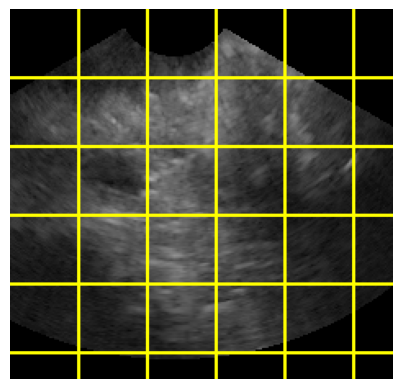

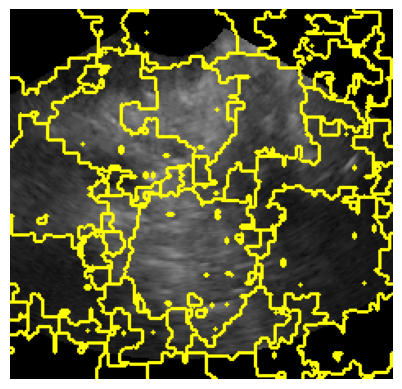

In [204]:
img = bmode['data4d'][:,:,:].squeeze()
p = SEEDSProcessor(image=img,  K=300, N_L=4, N=5, bin=16, alpha=0.01,gama=1)

#p.init_clusters()
#print(np.count_nonzero(p.boundary))

p.iterate_times(10)

### results

Text(0.5, 1.0, '3D segmented SEEDS')

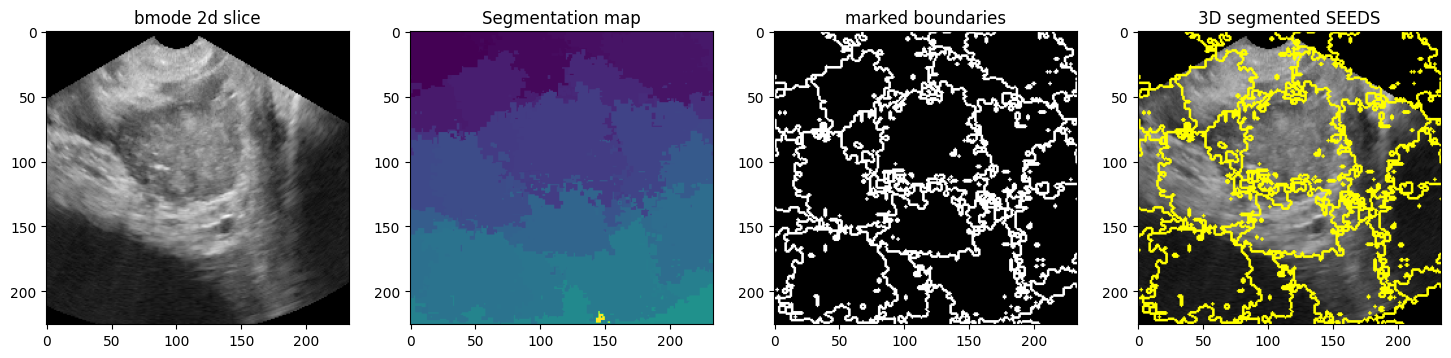

In [314]:
plt.figure(figsize=(18,4))
plt.subplot(1,4,1)
plt.imshow(img[25,:,:], cmap='gray')
plt.title("bmode 2d slice")
plt.subplot(1,4,2)
plt.imshow(p.Segment[25,:,:])
plt.title("Segmentation map")
#plt.imshow(p.hist[25,:,:],cmap='gray')
#plt.title("binned image")
plt.subplot(1,4,3)
plt.imshow(find_boundaries(p.Segment[25,:,:]),cmap='gray')
plt.title("marked boundaries")

plt.subplot(1,4,4)
#plt.imshow(img[25,:,:], cmap='gray')
plt.imshow(mark_boundaries(img[25,:,:],p.Segment[25,:,:],mode='inner')) 
plt.title("3D segmented SEEDS")




In [294]:
for i in trange(10):
    p.assignment(0)

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


### No need to check

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


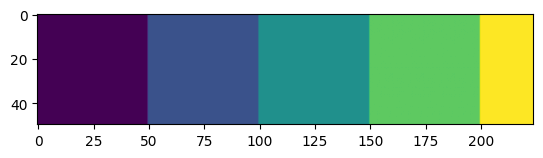

In [169]:
plt.imshow(p.Segment[:,:,0])
print(np.where(p.Segment[:,:,0]==0))
a = np.where(p.Segment[:,:,2]==0)
print(a)
plt.scatter(a[0],a[1],marker='x',color='r')

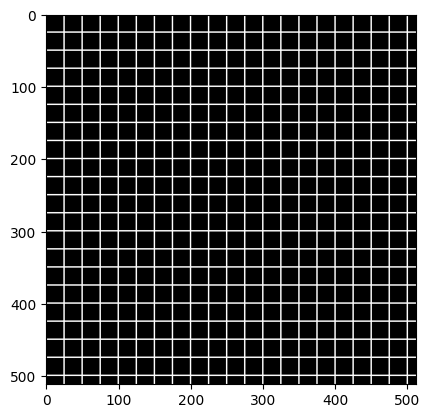

In [59]:
plt.imshow(p.boundary[:,:,0],cmap='gray')

In [222]:
print(p.hist[p.Segment==372])


a = np.unique(p.hist[p.Segment==372],return_counts=True)
print(a)
print(b)

[0. 0. 0. ... 0. 0. 0.]
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([134, 114,  39,  36,  34,  22,  24,  35, 812]))
(array([1]), array([5]))


In [184]:
cluster = p.clusters[102]
num = cluster.num_pixels

print(cluster.num_pixels)
print(np.array(cluster.color_hist).shape)
print(np.sum(np.array(cluster.color_hist)/num))
print(len(cluster.color_bins))


1250
(11,)
1.0
12


In [202]:

from collections import Counter
a = np.array([5,5,2,2,2,3,3,3,3])

#counts = np.bincount(a)
counts = np.unique(a,return_counts=True)
b = np.arange(np.min(a),np.max(a))
print(b)
print(counts[0])

[2 3 4]
[2 3 5]


In [171]:
a = p.Segment[:,:,:].flatten()
bins = np.max(a)-np.min(a)
print(bins)
print(p.Segment[10,:,0])
boundary_hist, expo_clusters= np.histogram(p.Segment.flatten(),int(bins))

print(np.max(a),np.min(a))
print(boundary_hist,expo_clusters)

441
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 1

(512, 512, 3)
(512, 512, 3)
(260496, 2)
[138286  64154 192714 157963 206546 118543 141865 236589 134999 209105]
[[270 316]
 [125 279]
 [378 181]
 [309 314]
 [405 216]
 [231 502]
 [277 318]
 [464 110]
 [264  95]
 [410 220]]
270 316
125 279
378 181
309 314
405 216
231 502
277 318
464 110
264 95
410 220


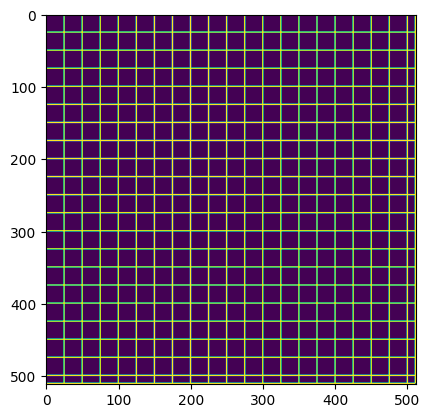

In [206]:
print(p.Segment.shape)
print(p.boundary.shape)
boundary = find_boundaries(p.Segment)
plt.imshow(boundary[:,:,0])
boundary_pixels = np.argwhere(boundary[:,:,2])
print(boundary_pixels.shape)
iteration_pixels = np.random.choice(range(boundary_pixels.shape[0]),10)
print(iteration_pixels)
print(boundary_pixels[iteration_pixels])

for h,w in boundary_pixels[iteration_pixels]:
    print(h,w)

In [31]:
N = 9
N_step = int(N/2)

a= np.histogram(p.Segment[10-N_step:10+N_step+1,10-N_step:10+N_step+1,10-N_step:10+N_step+1].flatten())
print(a[0]/(N*N*N))
b = a[0]/(N*N*N)
print(np.sum(b*b))
print(p.Segment[1-N_step:1+N_step+1,1-N_step:1+N_step+1,1-N_step:1+N_step+1].shape)

[0.66666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.33333333]
0.5555555555555556
(0, 0, 0)


In [59]:
print(p.Segment[5,:,2])

[151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151.
 151. 151. 151. 165. 165. 165. 165. 165. 165. 165. 165. 165. 165. 165.
 165. 165. 165. 165. 165. 165. 179. 179. 179. 179. 179. 179. 179. 179.
 179. 179. 179. 179. 179. 179. 179. 179. 179. 193. 193. 193. 193. 193.
 193. 193. 193. 193. 193. 193. 193. 193. 193. 193. 193. 193. 207. 207.
 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207.
 207. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221.
 221. 221. 221. 221. 235. 235. 235. 235. 235. 235. 235. 235. 235. 235.
 235. 235. 235. 235. 235. 235. 235. 249. 249. 249. 249. 249. 249. 249.
 249. 249. 249. 249. 249. 249. 249. 249. 249. 249. 263. 263. 263. 263.
 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 277.
 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277.
 277. 277. 291. 291. 291. 291. 291. 291. 291. 291. 291. 291. 291. 291.
 291. 291. 291. 291. 291. 305. 305. 305. 305. 305. 305. 305. 305. 305.
 305. 

467631
(10, 224, 234)
AxesImage(80,52.8;496x369.6)


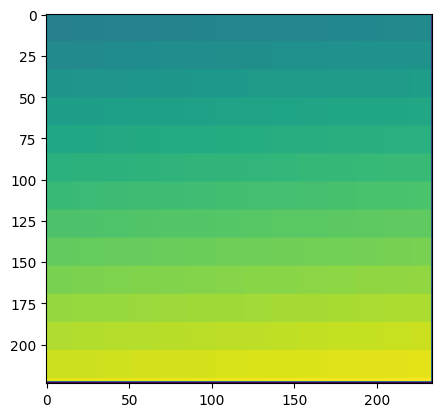

In [60]:
print(np.count_nonzero(p.Segment))
print(p.Segment.shape)

print(plt.imshow(p.Segment[5,:,:]))